here we will start to reduce the number of feature as for sure not all these 

features have an impact on the response varaible and we will try to generate more relvenat features

help us in our task

In [1]:
import pandas as pd 
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import  classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
import ppscore as pps
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

/home/mohand/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/mohand/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/mohand/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# 1-Remove nullable features

As we proposed in the previous notebook that if we have missing values exceeds 35 % we will

drop that feature.

In [2]:
Data=pd.read_csv("../Data/application_train.csv",index_col='SK_ID_CURR')

In [3]:
All_features=Data.columns.to_list()

In [4]:
nulls_df=pd.DataFrame((Data.isna().sum()/Data.shape[0])*100,columns=['ratio of null']).sort_values(by='ratio of null',ascending=False)

In [5]:
Features_to_drop=nulls_df[nulls_df['ratio of null']>30].index.tolist()

# Generate some features

In [6]:
Data['NEW_CREDIT_TO_ANNUITY_RATIO'] = Data['AMT_CREDIT'] / Data['AMT_ANNUITY']
Data['NEW_CREDIT_TO_GOODS_RATIO'] = Data['AMT_CREDIT'] / Data['AMT_GOODS_PRICE']
Data['EXT_SRC_TOT']=Data.EXT_SOURCE_2+Data.EXT_SOURCE_3

# 2-Remove correlated features

First Search for multicolinearity in features to drop them

Text(0.5, 1.0, 'HEATMAP OF CORR')

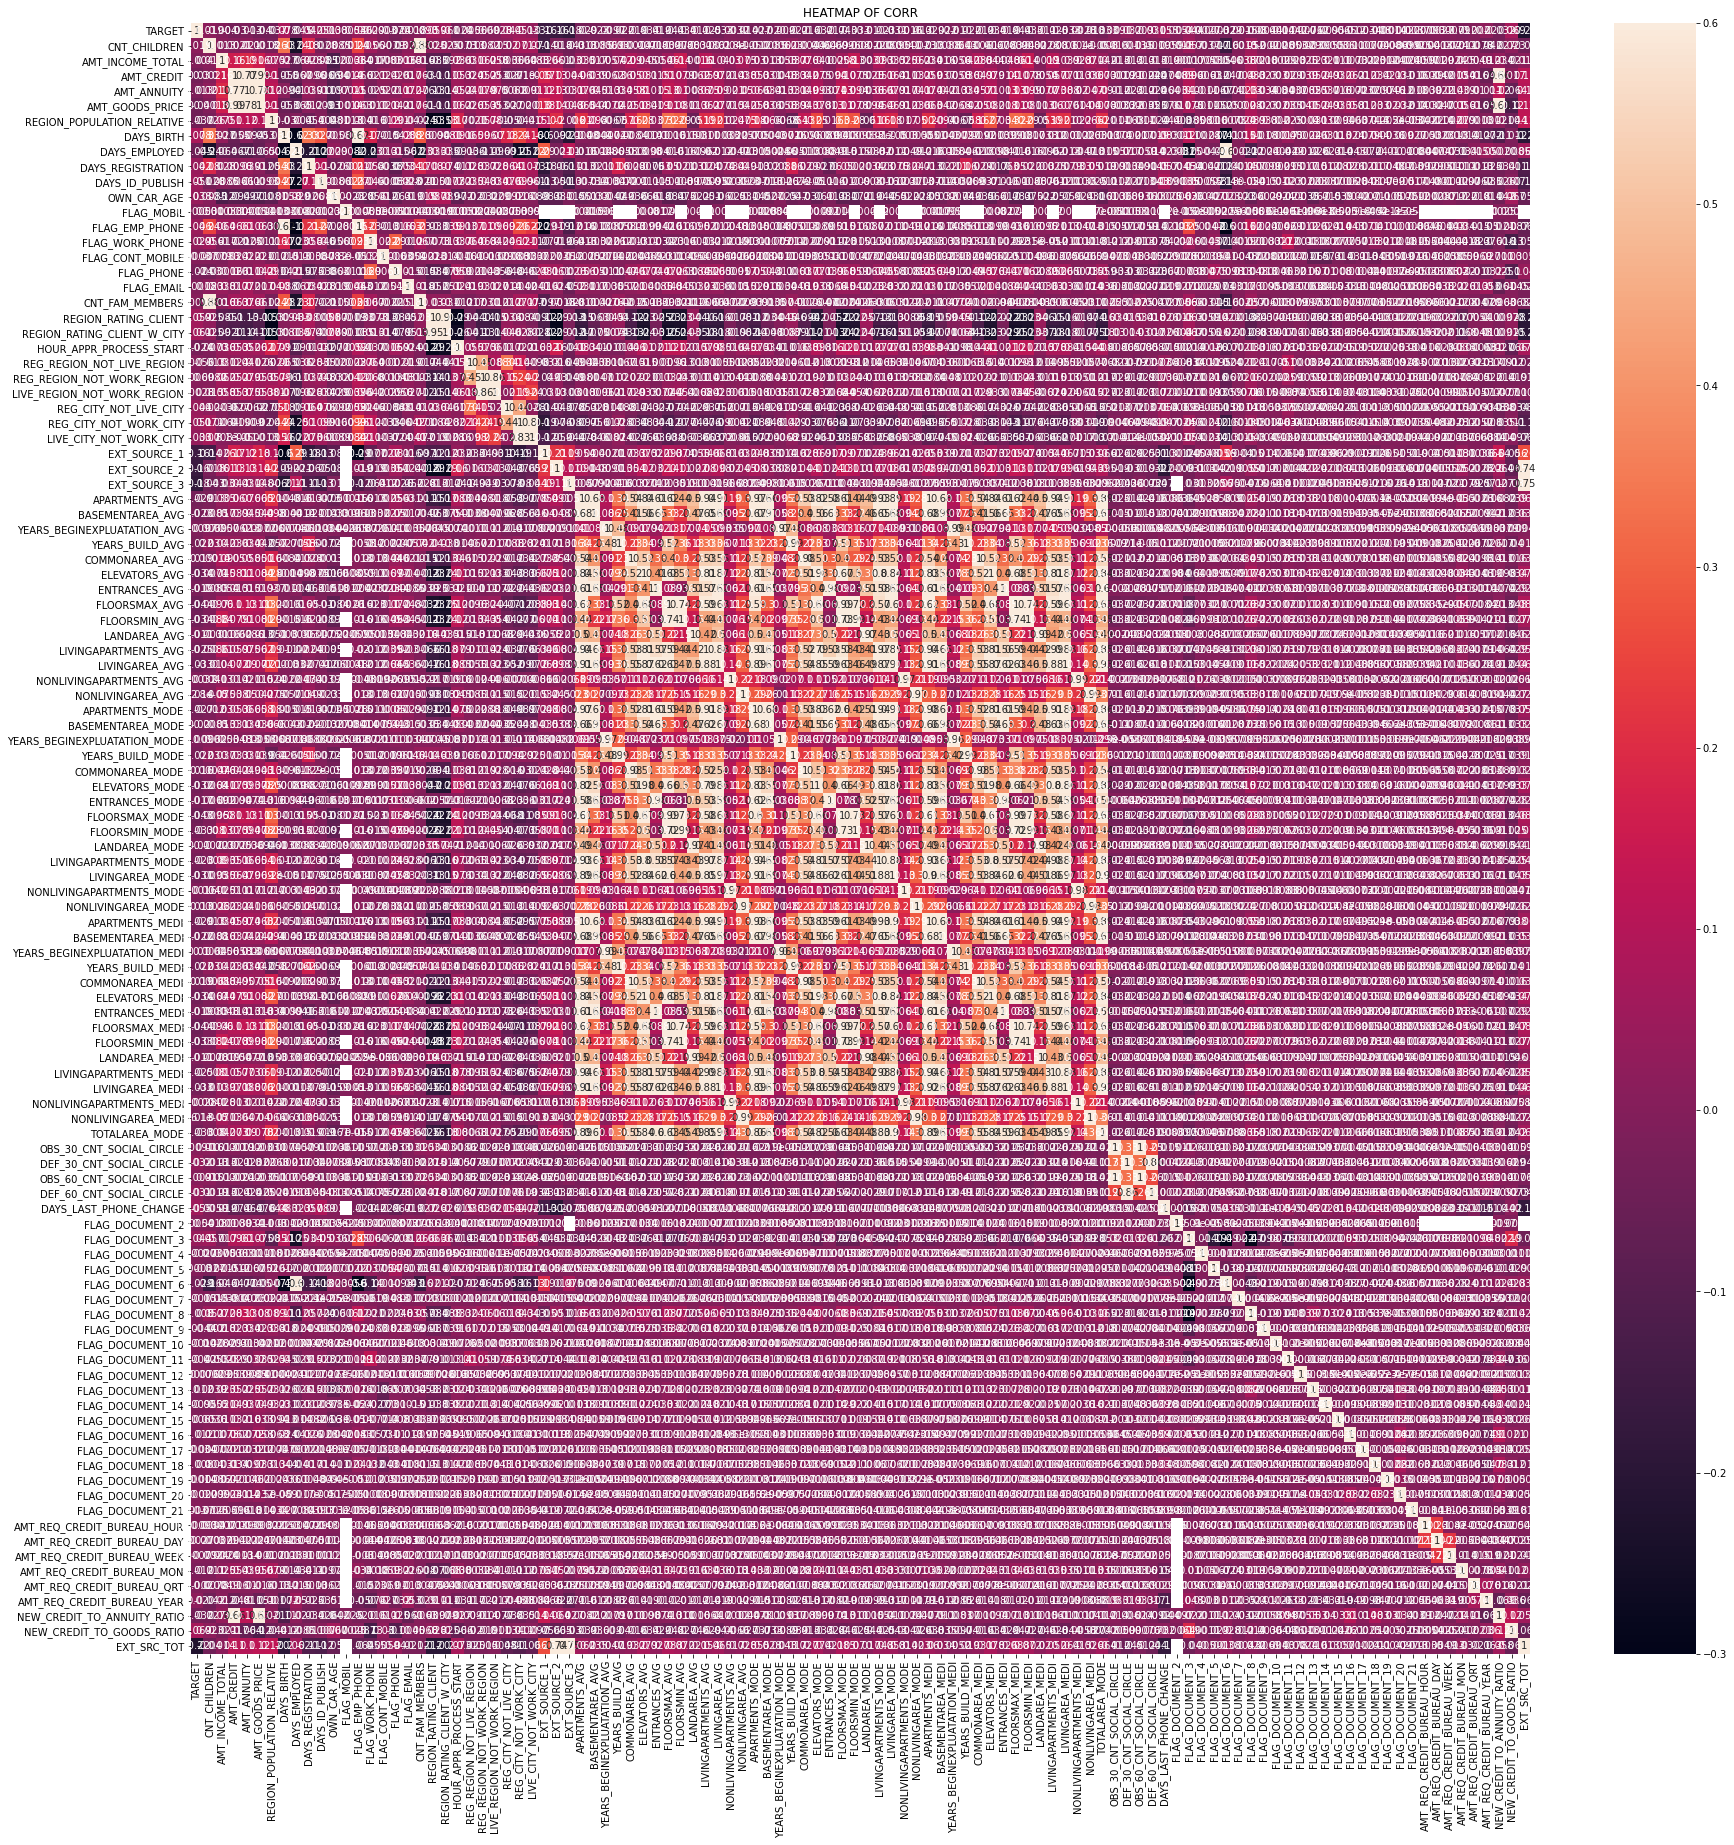

In [7]:
plt.figure(figsize=(30,30))
sns.heatmap(Data.corr(),vmin=-0.3,vmax=0.6,annot=True);
plt.title("HEATMAP OF CORR")

As we thought there is multicolinearity with some features which if we kept will cause unstability

in our model's parmaeters so we will remove one of each pair.

In [8]:
Features_to_drop_2=['CNT_FAM_MEMBERS','LIVE_REGION_NOT_WORK_REGION','DAYS_EMPLOYED','OBS_60_CNT_SOCIAL_CIRCLE','AMT_CREDIT','AMT_GOODS_PRICE']

In [9]:
tot_feature_to_drop=Features_to_drop+Features_to_drop_2
Data=Data.drop(tot_feature_to_drop,axis=1)

In [10]:
Categorical_features=[f for f in Data.columns  if Data[f].dtype=='O']
Numerical_features=[f for f in Data.columns  if Data[f].dtype!='O' and f!='TARGET']

In [11]:
len(Categorical_features)

11

In [12]:
len(Numerical_features)

56

# Divide Dataset

In [13]:
y=Data.TARGET
X=Data.drop('TARGET',axis=1)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2-Impute remaining features

feature imputation dependant on the type of feature :

if categorical we will go for the mode value 

if numerical we can go for [mean , median , mode , or knn imputer , itertative imputer....]

we will discard the mean as most of features are skewed as we so and also discard the mode as it 

will destory any trend exist in the data.

i will go for the median to be robosut to skewness also we can try knn imputer or iterative imputer.

In [15]:
cat_imputer = SimpleImputer( missing_values=np.nan,strategy='most_frequent').fit(X_train[Categorical_features])
num_imputer = SimpleImputer( missing_values=np.nan,strategy='median').fit(X_train[Numerical_features])

In [33]:
Categorical_features

['WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FLAG_OWN_REALTY',
 'NAME_FAMILY_STATUS',
 'NAME_TYPE_SUITE',
 'CODE_GENDER']

In [34]:
def impute_features(cat_imputer,num_imputer,train=True):
    if train:
            X_train[Categorical_features]=cat_imputer.transform(X_train[Categorical_features])
            X_train[Numerical_features]=num_imputer.transform(X_train[Numerical_features])
            X_train['CODE_GENDER'].replace('XNA',cat_imputer.statistics_[-1],inplace=True)
            X_train['NAME_FAMILY_STATUS'].replace('Unknown',cat_imputer.statistics_[3], inplace=True)
            X_train['ORGANIZATION_TYPE'].replace(cat_imputer.statistics_[1],inplace=True)
    else: 
            X_valid[Categorical_features]=cat_imputer.transform(X_valid[Categorical_features])
            X_valid[Numerical_features]=num_imputer.transform(X_valid[Numerical_features])
            X_valid['CODE_GENDER'].replace('XNA',cat_imputer.statistics_[-1],inplace=True)
            X_valid['NAME_FAMILY_STATUS'].replace('Unknown',cat_imputer.statistics_[3], inplace=True)
            X_valid['ORGANIZATION_TYPE'].replace(cat_imputer.statistics_[1],inplace=True)

=============================================================================================

There is alot of ways to identify relevant features to the model we will try two of them:

1-look at the correlation between features and the target selecting most linear correlated features.  [Done]


2- fit a naive extra tree and get feature importance 

if feature used to split the tree near the root then it's higher importance 

decision tree can capture non linear effective features.



we can try other univariate statistical ways to identify dependance between target and feature like

t-test, chisquare and anova.

In [17]:
impute_features(cat_imputer,num_imputer)

In [18]:
X_encoded = pd.get_dummies(X_train, columns=Categorical_features)
X_encoded.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 310536 to 430259
Data columns (total 161 columns):
 #    Column                                             Non-Null Count   Dtype  
---   ------                                             --------------   -----  
 0    CNT_CHILDREN                                       246008 non-null  float64
 1    AMT_INCOME_TOTAL                                   246008 non-null  float64
 2    AMT_ANNUITY                                        246008 non-null  float64
 3    REGION_POPULATION_RELATIVE                         246008 non-null  float64
 4    DAYS_BIRTH                                         246008 non-null  float64
 5    DAYS_REGISTRATION                                  246008 non-null  float64
 6    DAYS_ID_PUBLISH                                    246008 non-null  float64
 7    FLAG_MOBIL                                         246008 non-null  float64
 8    FLAG_EMP_PHONE                                     246008

Note: Extra trees is better than decision trees for the sake of time as for continous

features it chooses random values to split on instead of asking all possible questions.

In [19]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_encoded, y_train)

ExtraTreesClassifier(n_estimators=10)

In [20]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X_encoded.columns
feature_importance_df['importance'] = feature_importances

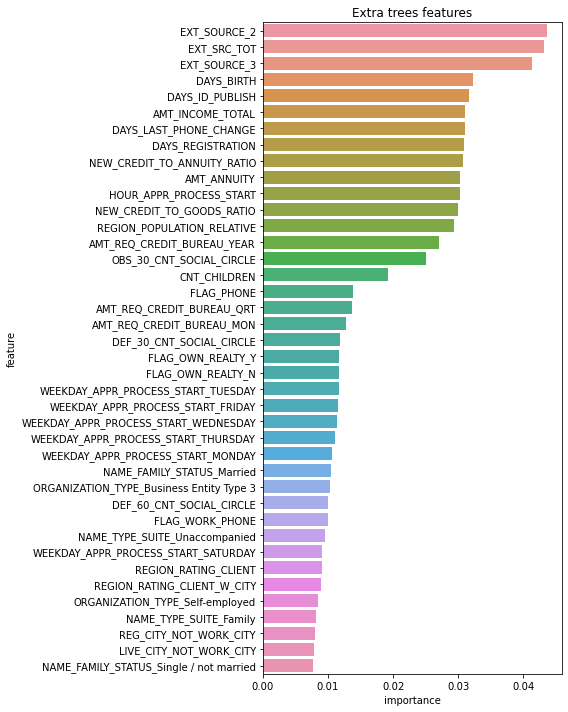

In [21]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Extra trees features')
plt.tight_layout()

===================================================================================

Most Correlated features with the target

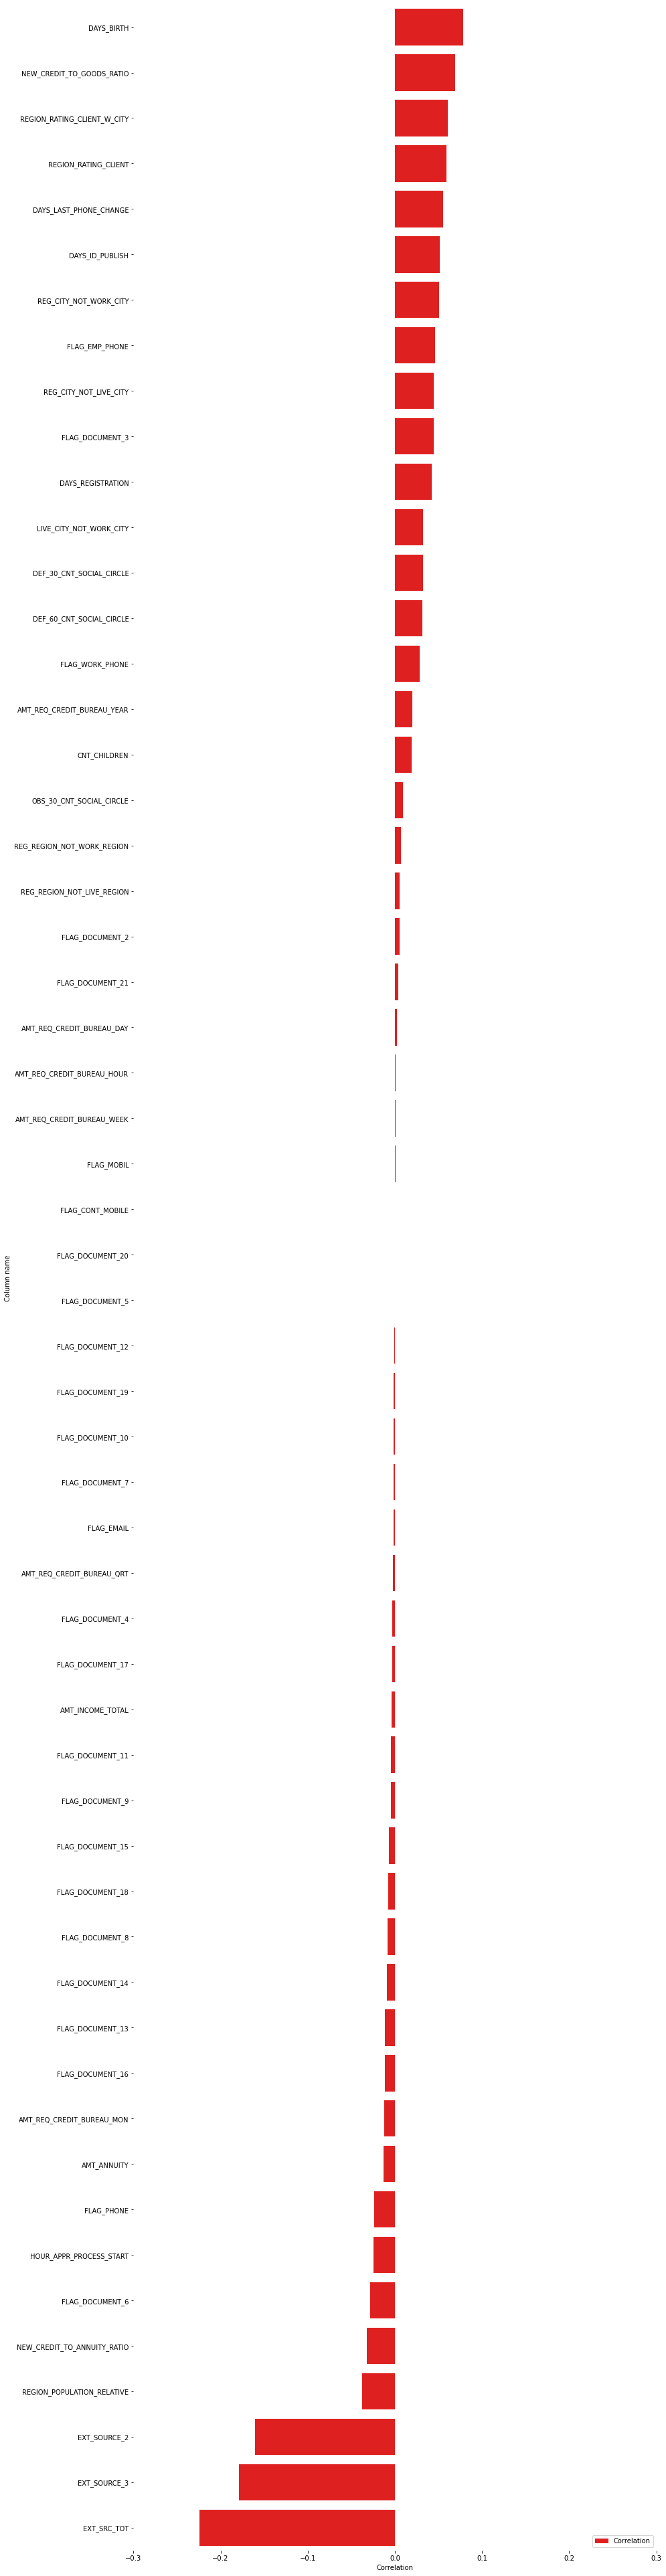

In [22]:
plt.figure(figsize=(14,70))
# sns.set_color_codes("dark")
y_corr = Data.corr().loc["TARGET"].sort_values(ascending=False).drop("TARGET",axis = 0).dropna()

ax = sns.barplot(y=y_corr.index.values, x=y_corr.values,
            label="Correlation", color="r")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(-0.3, 0.3), ylabel="Column name",
       xlabel="Correlation")
sns.despine(left=True, bottom=True)

In [23]:
Features_to_keep=['EXT_SRC_TOT', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE',
       'HOUR_APPR_PROCESS_START', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY','REGION_POPULATION_RELATIVE', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'AMT_REQ_CREDIT_BUREAU_YEAR','OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'FLAG_PHONE','AMT_REQ_CREDIT_BUREAU_MON','WEEKDAY_APPR_PROCESS_START','DEF_30_CNT_SOCIAL_CIRCLE',
        'ORGANIZATION_TYPE','FLAG_OWN_REALTY','FLAG_WORK_PHONE','NAME_FAMILY_STATUS','NAME_TYPE_SUITE',
        'DEF_60_CNT_SOCIAL_CIRCLE','REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_WORK_CITY','CODE_GENDER']

# 4-Choice of the model

when it comes to choose the model we need a model that compensate with the problems 

in our dataset and only serves the buisness requirements :

-as we said before we need a model with high recall and F score

-it doesn't matter if inference take some time

-we need high interpretability and output should be on the form of probabilites

-it would be better if the model roboust to both outliers and scaling as most of our features

are skewed and not on same scale.

-Model should be high bias low variance one to compensate with the data as we have alot of records

in our data which should solve problem of bias but we choose some of features which is not too 

relevant to our model so we can predict that we would have large variance

===============================================================

for these specs we will favor  trees algorithms and to overcome variance we will 

favor one of boosting or bagging techniques :

1-random forrest 

2-xgboost 

3-lightboost

In [24]:
Data=Data.loc[:,Features_to_keep]

# Baseline Model

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(Data, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
Categorical_features=[f for f in X_train.columns  if X_train[f].dtype=='O']
Numerical_features=[f for f in X_train.columns  if X_train[f].dtype!='O' and f!='TARGET']

In [27]:
cat_imputer = SimpleImputer( missing_values=np.nan,strategy='most_frequent').fit(X_train[Categorical_features])
num_imputer = SimpleImputer( missing_values=np.nan,strategy='median').fit(X_train[Numerical_features])

In [35]:
impute_features(cat_imputer,num_imputer,train=True)

In [36]:
impute_features(cat_imputer,num_imputer,train=False)

In [37]:
OEnc=OrdinalEncoder()
X_train[Categorical_features]=OEnc.fit_transform(X_train[Categorical_features])
X_valid[Categorical_features]=OEnc.transform(X_valid[Categorical_features])

We decided to go with ordinal encoding rather than ohe to reduce sparesity of data as it hurts

the performance in case of tree based model used  

check this: https://stackoverflow.com/questions/65722374/one-hot-encoding-in-random-forest-classifier

In [38]:
rf=RandomForestClassifier(max_depth=25)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=25)

In [39]:

prob_preds=rf.predict_proba(X_valid)
print('AUC: ', roc_auc_score(y_valid, prob_preds[:,1]))

AUC:  0.7201892821008867


In [42]:
Data.loc[:,'TARGET']=y

In [43]:
Data.to_csv("../Data/Final_prepared_data.csv")

We will build last model pipeline in next notebook to avoid confliction.

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

1-choose features to keep

In [44]:
relev_features=['EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_REGISTRATION','AMT_INCOME_TOTAL','DAYS_LAST_PHONE_CHANGE','AMT_CREDIT','AMT_GOODS_PRICE']
len(relev_features)

9

In [45]:
X_train=X_train[relev_features]
X_valid=X_valid[relev_features]

2- define a function to add new features to new test data

In [46]:
def NEW_CREDIT_TO_GOODS_RATIO(Data):
    Data['NEW_CREDIT_TO_GOODS_RATIO'] = Data['AMT_CREDIT'] / Data['AMT_GOODS_PRICE']
    return Data[['NEW_CREDIT_TO_GOODS_RATIO']]

def Total_EXTERNAL_SRC(Data):
       Data['EXT_SRC_TOT']=Data.EXT_SOURCE_2+Data.EXT_SOURCE_3
       return Data[['EXT_SRC_TOT']]



3-impute_missing_vals

In [47]:
num_imputer = SimpleImputer( missing_values=np.nan,strategy='median')

4-Define model

In [48]:
rf=RandomForestClassifier()

5-Design whole pipeline

In [49]:
Feature_Engineering = ColumnTransformer(
    transformers=[
         ('EXT_SRC_TOT', FunctionTransformer(Total_EXTERNAL_SRC, validate=False),
        ['EXT_SOURCE_2','EXT_SOURCE_3'],),
       ('NEW_CREDIT_TO_GOODS_RATIO', FunctionTransformer(NEW_CREDIT_TO_GOODS_RATIO, validate=False),
       ['AMT_CREDIT','AMT_GOODS_PRICE'])])
        

In [50]:
pipeline = Pipeline(steps=[('Feature Engineering', Feature_Engineering ),
                           ('imputer',num_imputer),
                           ('model', rf)])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(transformers=[('EXT_SRC_TOT',
                                                  FunctionTransformer(func=<function Total_EXTERNAL_SRC at 0x7f62fa9c2ca0>),
                                                  ['EXT_SOURCE_2',
                                                   'EXT_SOURCE_3']),
                                                 ('NEW_CREDIT_TO_GOODS_RATIO',
                                                  FunctionTransformer(func=<function NEW_CREDIT_TO_GOODS_RATIO at 0x7f62fa9c21f0>),
                                                  ['AMT_CREDIT',
                                                   'AMT_GOODS_PRICE'])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('model', RandomForestClassifier())])

In [51]:
prediction=pipeline.predict_proba(X_valid)
print('AUC: ', roc_auc_score(y_valid, prediction[:,1]))

AUC:  0.6081070945627136


In [52]:
print(classification_report(y_valid, prediction))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets